In [1]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)

from transformers import *
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold

from sklearn.base import clone

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

In [2]:
# Load Data
import cPickle as pickle
train_pd  = pd.read_pickle('saved/train_pd_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))



In [3]:
train = np.array(train_pd)
test = np.array(test_pd)


X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)

pipe_x = make_pipeline(
    make_union(
        IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         make_pipeline(AddTformer(1), GLogTformer()),
#         AnscombeTformer(),
#         LogTformer(),
    ),

#     MinMaxScaler(feature_range=(-1, 1)),
    StandardScaler(),
)
pipe_y = make_pipeline(
#     AddTformer(-1),
#     LogTformer(),
#     AnscombeTformer(),
    StandardScaler(),
)
pipe_x.fit(np.r_[X_train, X_test])


X_train = pipe_x.transform(X_train)
X_test = pipe_x.transform(X_test)
# y_train = pipe_y.fit_transform(y_train)

# # small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]

print y_train.shape
print X_train.shape
print X_test.shape
print len(np.unique(y_train))

(50999,)
(50999, 111)
(51000, 111)
50


# Keras

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, MaxoutDense, Reshape
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adadelta, Adagrad, Adam, RMSprop
from keras.utils import np_utils

losses = []
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))

Using gpu device 0: GeForce GTX 580


In [13]:
model = Sequential()

hidden_size = 256

model.add(Dense(111, hidden_size))
model.add(Dropout(0.2))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(hidden_size, hidden_size))
# model.add(Activation('relu'))
# model.add(PReLU(hidden_size))
model.add(MaxoutDense(hidden_size, hidden_size, 2))
model.add(BatchNormalization(hidden_size))
model.add(Dropout(0.5))
model.add(Dense(hidden_size, 2))

# model.add(Dense(111, 1024))
# model.add(Dropout(0.1))
# model.add(MaxoutDense(1024, 1024, 2))
# model.add(Dropout(0.5))
# model.add(MaxoutDense(1024, 1024, 2))
# model.add(Dropout(0.5))
# model.add(MaxoutDense(1024, 1024, 2))
# model.add(Dropout(0.5))
# model.add(Dense(1024, 2))

model.compile(
#     loss='binary_crossentropy', 
    loss='squared_hinge', 
    optimizer='rmsprop', 
    class_mode='binary')

model.save_weights('saved/nn_weights', overwrite=True)

In [ ]:
print y_train
y_bin = (y_train > 1).astype(int)
y_bin_keras = np_utils.to_categorical(y_bin, 2)
print y_bin_keras.sum(axis=0)

[ 1  4  1 ...,  3 14  9]
[ 18981.  32018.]


In [ ]:
tic = time()

model.load_weights('saved/nn_weights')
history = model.fit(X_train, y_bin_keras, 
                    nb_epoch=60, batch_size=1024*16, 
                    verbose=2, show_accuracy=True, 
                    validation_split=0.5)

print 'Fit time:', time() - tic

Train on 25499 samples, validate on 25500 samples
Epoch 0
0s - loss: 0.9909 - acc: 0.5000 - val_loss: 0.9528 - val_acc: 0.5000
Epoch 1
0s - loss: 0.9493 - acc: 0.5000 - val_loss: 0.9182 - val_acc: 0.5000
Epoch 2
0s - loss: 0.9132 - acc: 0.5000 - val_loss: 0.8824 - val_acc: 0.5000
Epoch 3
0s - loss: 0.8806 - acc: 0.5002 - val_loss: 0.8539 - val_acc: 0.5002
Epoch 4
0s - loss: 0.8533 - acc: 0.5007 - val_loss: 0.8277 - val_acc: 0.5019
Epoch 5
0s - loss: 0.8281 - acc: 0.5014 - val_loss: 0.8032 - val_acc: 0.5028
Epoch 6
0s - loss: 0.8029 - acc: 0.5031 - val_loss: 0.7799 - val_acc: 0.5044
Epoch 7
0s - loss: 0.7794 - acc: 0.5066 - val_loss: 0.7573 - val_acc: 0.5060
Epoch 8
0s - loss: 0.7573 - acc: 0.5115 - val_loss: 0.7355 - val_acc: 0.5187
Epoch 9
0s - loss: 0.7353 - acc: 0.5225 - val_loss: 0.7152 - val_acc: 0.5292
Epoch 10
0s - loss: 0.7128 - acc: 0.5387 - val_loss: 0.6939 - val_acc: 0.5543
Epoch 11
0s - loss: 0.6937 - acc: 0.5587 - val_loss: 0.6745 - val_acc: 0.5839
Epoch 12
0s - loss: 0.67

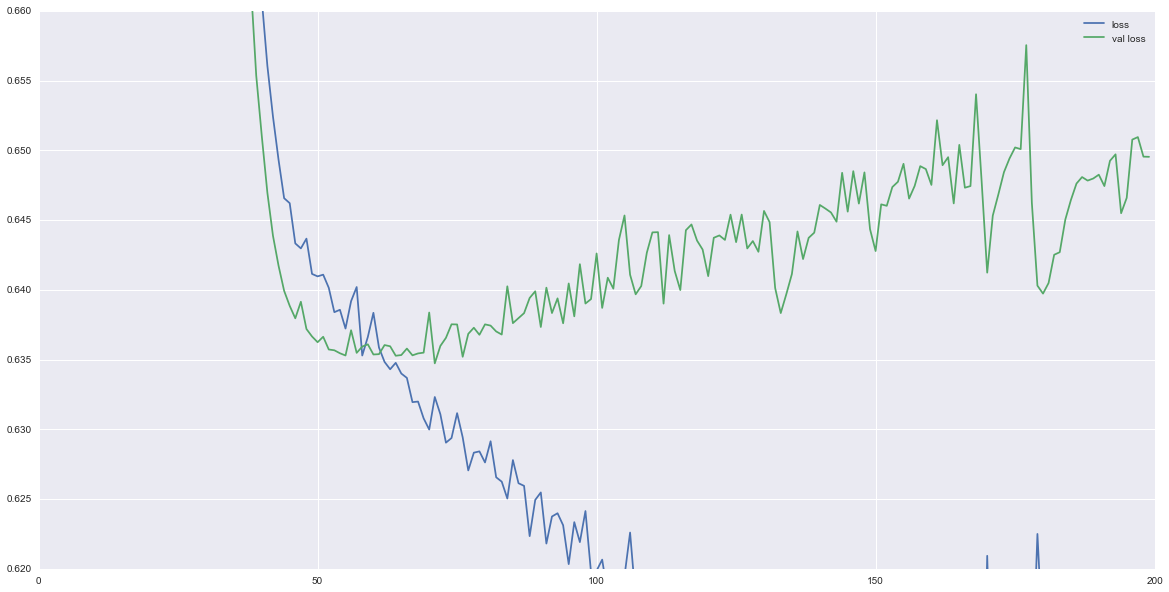

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

v = history.history['val_loss']
l = history.history['loss']
e = history.epoch
plt.plot(e, l, label='loss')
plt.plot(e, v, label='val loss')
plt.ylim([0.62, 0.66])
plt.legend()


[.6325]@200 <== 111 stdscaler 0.2 input dropout
[.6312]@300 <== 111 stdscaler 0.2 input dropout with prelu and batch norm
[.6300]@300 <== 111 stdscaler 0.2 input dropout with maxout256/2 and batch norm

In [90]:
scores = []
scores_base = []
n_reps = 1
k = 3
for reps in range(n_reps):
    skf = StratifiedKFold(y_train, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        model.load_weights('saved/nn_weights')
        
        
        history = LossHistory()   # for keras
        print 'Fold %d' % ii,
        X_train_k = X_train[train]
        X_valid_k = X_train[valid]
        y_train_k = y_train[train]
        y_valid_k = y_train[valid]
        
        tic = time()
#         clf.fit(X_train_k, y_train_k)
        
#         clf.fit(X_train_k, y_train_k, batch_size=16384, nb_epoch=200)
    
        model.fit(X_train_k, y_train_k, 
                  nb_epoch=400, batch_size=16384,
                  validation_data=(X_valid_k, y_valid_k),
                  callbacks=[history],
                  verbose=0)
        
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc, 

#         valid_preds = clf.predict(X_valid_k)
#         valid_preds = clf.predict_proba(X_valid_k, batch_size=16384).flatten()
        valid_preds = model.predict_proba(X_valid_k, batch_size=16384, verbose=0).flatten()
        
#         score = metrics.gini(y_valid_k, valid_preds)
        score = metrics.normalized_gini(y_valid_k, valid_preds)
        
        print 'Score %1.5f' % score
        scores.append(score)
        
        losses.append(history.losses)
        
print "done"
print np.array(scores).mean()

Fold 0 Train time: 393.300 s	Score 0.28282
Fold 1 Train time: 393.319 s	Score 0.27174
Fold 2 Train time: 393.158 s	Score 0.28141
done
0.278656503096


0.278656503096


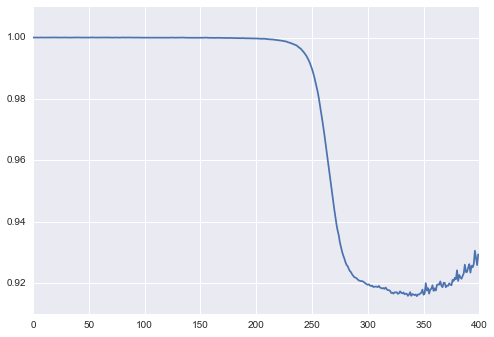

In [91]:
print np.array(scores).mean()
plt.plot(np.mean(losses, axis=0))
# plt.ylim([0.88, 0.94])
# plt.ylim([0.85, 1.0])

In [21]:
# 0.345 @ 512 maxout

{'loss': 'mean_absolute_error',
 'model': <keras.models.Sequential at 0x7f72ef18dbd0>,
 'optimizer': 'rmsprop'}

# Predict Test Set

In [60]:
model.compile(loss=loss_type, optimizer='rmsprop')
model.fit(X_train, y_train, 
          nb_epoch=10, batch_size=16384,
          callbacks=[history],
          verbose=0)

preds = model.predict_proba(X_test, batch_size=16384, verbose=0).flatten()

In [62]:
print preds.shape
print X_test.shape

(51000,)
(51000, 111)


# Generate submission

In [63]:
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('submissions/keras_benchmark.csv')